In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from minisom import MiniSom
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [6]:
# Load the dataset
tsunami = pd.read_csv(r'C:\Users\ungdu\Downloads\Smart-Decision\Tsunami_Cut.csv')
tsunami.head()

,Year,Mo,Tsunami Event Validity,Tsunami Cause Code,Earthquake Magnitude,Vol,Deposits,Country,Location Name,Latitude,...,Damage ($Mil),Damage Description,Houses Destroyed,Houses Destroyed Description,Total Deaths,Total Death Description,Total Damage ($Mil),Total Damage Description,Total Houses Destroyed,Total Houses Destroyed Description
0,-2000,NaN,1,1.0,NaN,NaN,0,SYRIA,SYRIAN COASTS,35.683,...,NaN,4.0,NaN,NaN,NaN,3.0,NaN,4.0,NaN,NaN
1,-1610,NaN,4,6.0,NaN,1351.0,28,GREECE,THERA ISLAND (SANTORINI),36.400,...,NaN,3.0,NaN,NaN,NaN,3.0,NaN,3.0,NaN,NaN
2,-1365,NaN,1,1.0,NaN,NaN,0,SYRIA,SYRIAN COASTS,35.683,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN
3,-1300,NaN,2,0.0,6.0,NaN,0,TURKEY,"IONIAN COASTS, TROAD",39.960,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-760,NaN,2,0.0,NaN,NaN,0,ISRAEL,ISRAEL AND LEBANON COASTS,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Filter rows where the year is greater than 1800
tsunami_filtered = tsunami[tsunami['Year'] > 1800]


In [8]:
# Filter relevant columns
tsunami_filtered = tsunami_filtered[['Latitude', 'Longitude', 'Tsunami Cause Code']]

In [9]:
# Handle missing values in the filtered columns
tsunami_filtered = tsunami_filtered.dropna()

In [10]:
# Normalize the data
scaler = StandardScaler()
tsunami_normalized = scaler.fit_transform(tsunami_filtered)

In [11]:
# Step 2: Implementing Self-Organizing Maps (SOMs)
som_size = int(len(tsunami_normalized) ** 0.5)
som = MiniSom(som_size, som_size, tsunami_normalized.shape[1], sigma=1.0, learning_rate=0.5)
som.train_random(tsunami_normalized, 100)
def get_winner_coords(data, som):
    return np.array([som.winner(x) for x in data])
som_clusters = get_winner_coords(tsunami_normalized, som)

In [12]:
# Step 3: Implementing Autoencoders
input_dim = tsunami_normalized.shape[1]
encoding_dim = 2
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(tsunami_normalized, tsunami_normalized, epochs=50, batch_size=16, shuffle=True)
encoder_model = Model(inputs=input_layer, outputs=encoder)
encoded_data = encoder_model.predict(tsunami_normalized)

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.1705 
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.1378
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0644  
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0301
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9583
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.9109
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 0.9062
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8825
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8485
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8227
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8225
Epoch 12/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7970
Epoch 13/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.7582
Epoch 14/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7770
Epoch 15/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

In [13]:
# Step 4: Clustering using SOMs and Autoencoders
combined_features = np.hstack((encoded_data, som_clusters))
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(combined_features)
tsunami_filtered['Cluster'] = clusters

In [14]:
# Step 5: Visualization on World Map using geopandas and contextily
gdf = gpd.GeoDataFrame(tsunami_filtered, geometry=gpd.points_from_xy(tsunami_filtered.Longitude, tsunami_filtered.Latitude))
gdf.set_crs(epsg=4326, inplace=True)

,Latitude,Longitude,Tsunami Cause Code,Cluster,geometry
611,45.300,14.400,9.0,4,POINT (14.40000 45.30000)
612,17.200,-62.400,1.0,3,POINT (-62.40000 17.20000)
614,10.300,-64.500,1.0,1,POINT (-64.50000 10.30000)
615,-3.700,128.200,1.0,2,POINT (128.20000 -3.70000)
616,45.700,26.600,1.0,2,POINT (26.60000 45.70000)
...,...,...,...,...,...
2856,-14.985,167.983,1.0,2,POINT (167.98300 -14.98500)
2857,8.527,126.449,1.0,3,POINT (126.44900 8.52700)
2858,-20.659,169.206,1.0,2,POINT (169.20600 -20.65900)
2859,37.498,137.242,3.0,3,POINT (137.24200 37.49800)


C:\Users\ungdu\AppData\Local\Temp\ipykernel_2972\2098609292.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
C:\Users\ungdu\AppData\Local\Temp\ipykernel_2972\2098609292.py:3: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  oceans = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


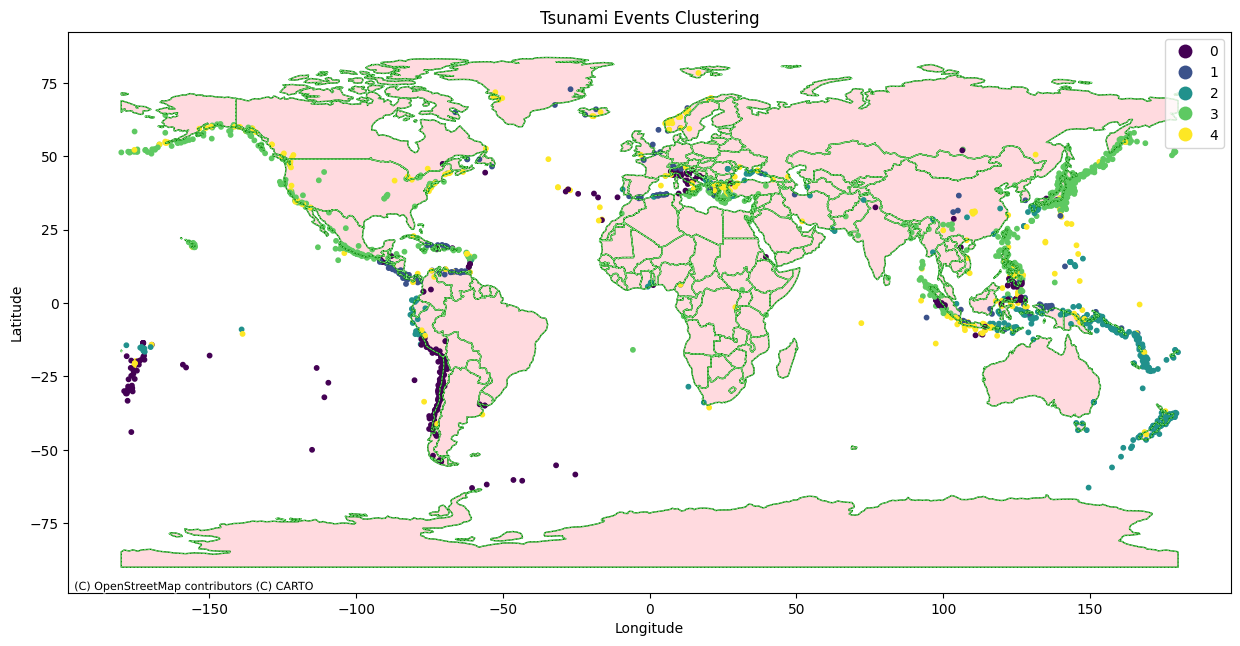

In [15]:
# Load Natural Earth features for continents and oceans
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
oceans = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title('Tsunami Events Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

     Latitude  Longitude  Tsunami Cause Code  Cluster
626    41.500     14.467                 1.0        0
628    41.700     12.700                 1.0        0
629   -12.100    -77.100                 1.0        0
631    44.833      7.250                 1.0        0
634    44.800      7.200                 1.0        0


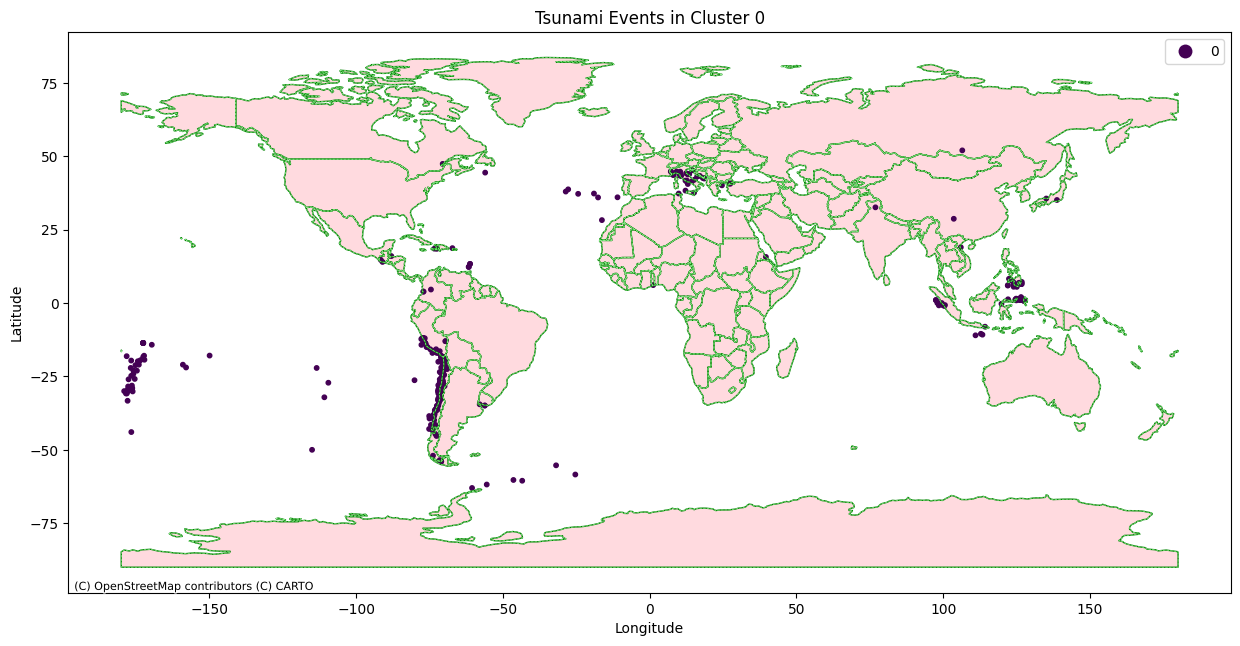

In [16]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 0  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Cụm 0: các sự kiện sóng thần tập trung chủ yếu ở khu vực Nam Mỹ (bờ biển phía tây của Chile và Peru) và một số vùng ở phía nam Thái Bình Dương. Đây có thể là các sự kiện có đặc điểm tương tự nhau về cường độ hoặc nguyên nhân gây ra.

     Latitude  Longitude  Tsunami Cause Code  Cluster
614    10.300    -64.500                 1.0        1
617    36.500      2.900                 1.0        1
620    36.083     -3.583                 1.0        1
648    10.600    -66.900                 1.0        1
677    66.416     12.850                 1.0        1


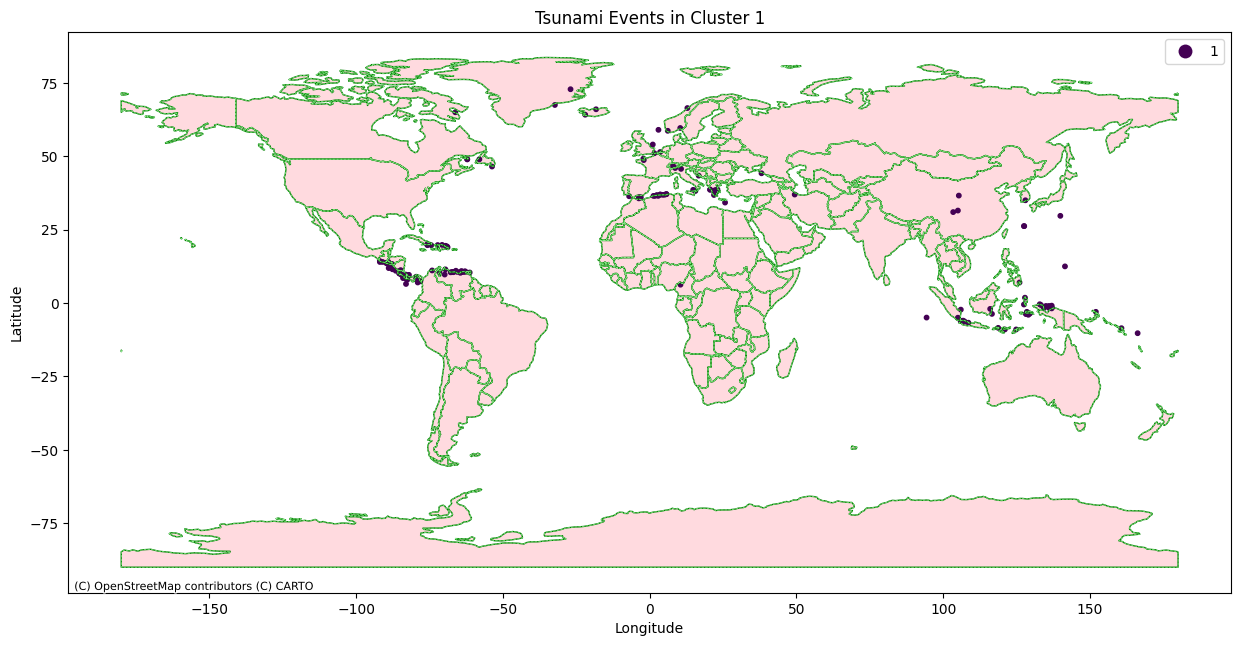

In [17]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 1  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Cụm 1:  vùng ven biển phía tây của Bắc Mỹ, đặc biệt là Alaska và bờ biển phía tây của Hoa Kỳ. Chúng cũng xuất hiện ở một số khu vực ở Địa Trung Hải. Các sự kiện trong cụm này có thể có những đặc điểm địa lý và địa chất tương đồng.


     Latitude  Longitude  Tsunami Cause Code  Cluster
615     -3.70     128.20                 1.0        2
616     45.70      26.60                 1.0        2
625    -29.06     167.95                 0.0        2
630     -9.00    -139.00                 0.0        2
636    -33.88      18.45                 1.0        2


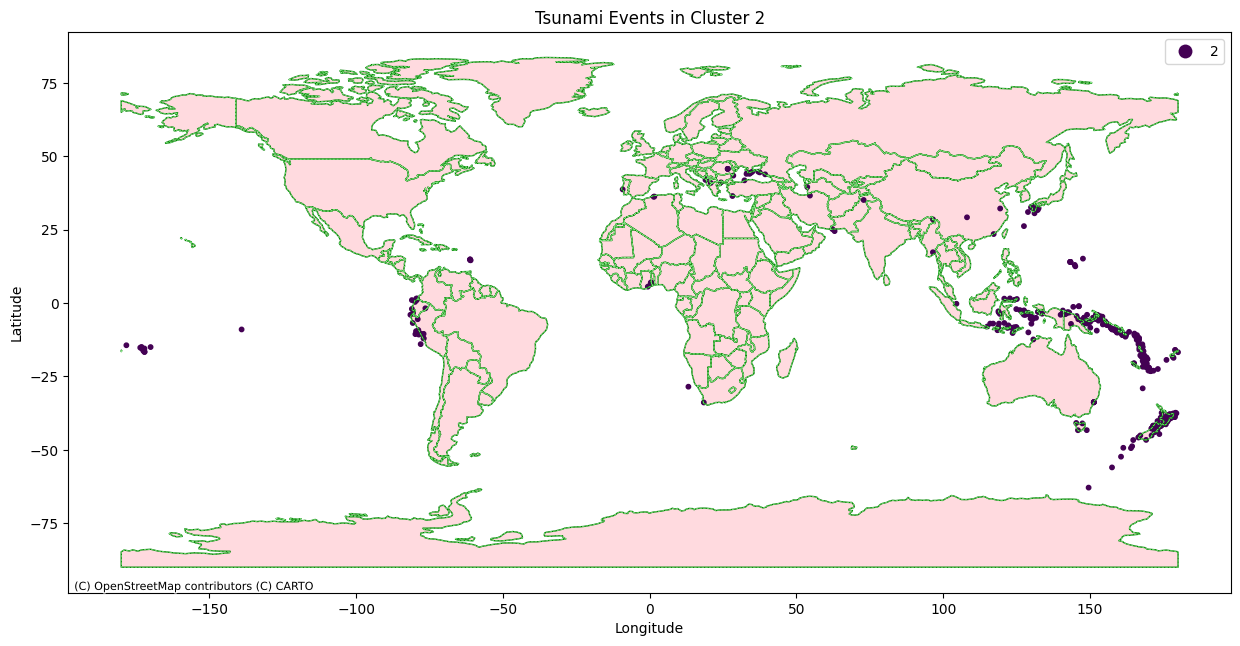

In [18]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 2  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Cụm 2: Đông Nam Á, đặc biệt là Indonesia và Philippines, cũng như một số khu vực ở châu Đại Dương. Đây là các khu vực có hoạt động địa chấn mạnh mẽ, dẫn đến các sự kiện sóng thần thường xuyên.

     Latitude  Longitude  Tsunami Cause Code  Cluster
612     17.20     -62.40                 1.0        3
618     37.70     138.30                 1.0        3
619     38.20      21.80                 1.0        3
621     38.30      21.80                 1.0        3
622     39.05     139.95                 1.0        3


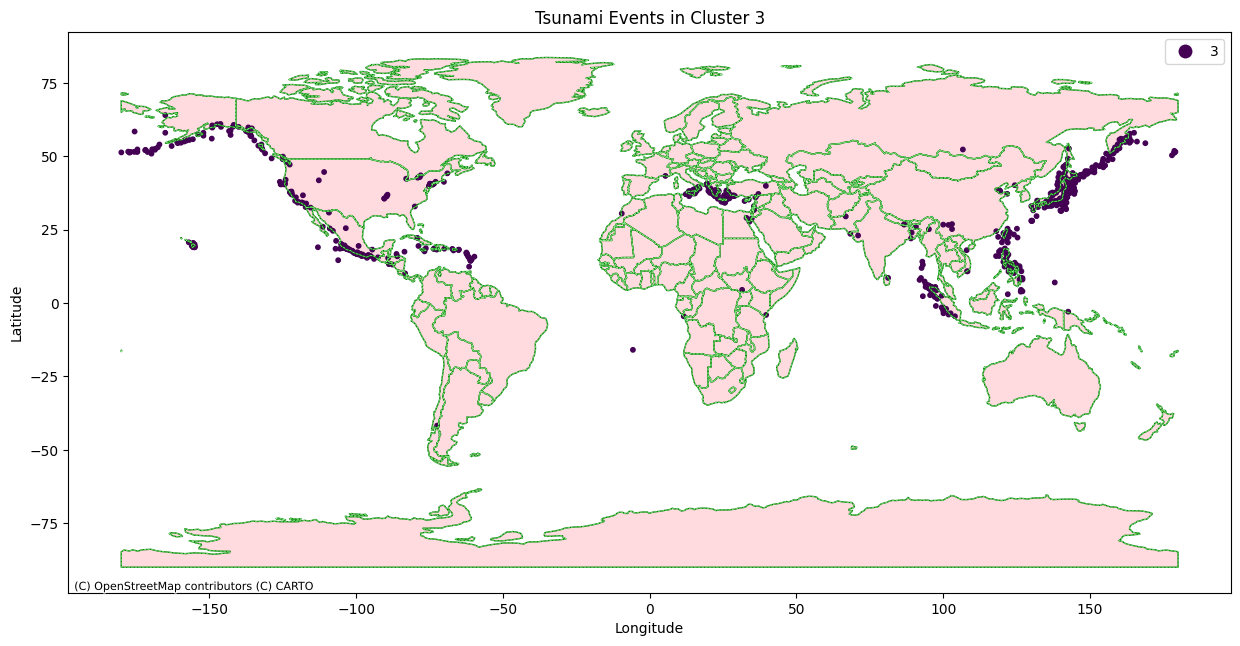

In [19]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 3  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Cụm 3: Thái Bình Dương, bao gồm Nhật Bản, quần đảo Kuril, và bờ biển phía đông của châu Á. Các sự kiện trong cụm này có thể liên quan đến hoạt động núi lửa và địa chấn ở vành đai Thái Bình Dương.

     Latitude  Longitude  Tsunami Cause Code  Cluster
611    45.300     14.400                 9.0        4
641    69.433     20.150                 8.0        4
653    40.817     14.433                 6.0        4
656    -8.200    118.000                 6.0        4
670    -4.000    101.500                 3.0        4


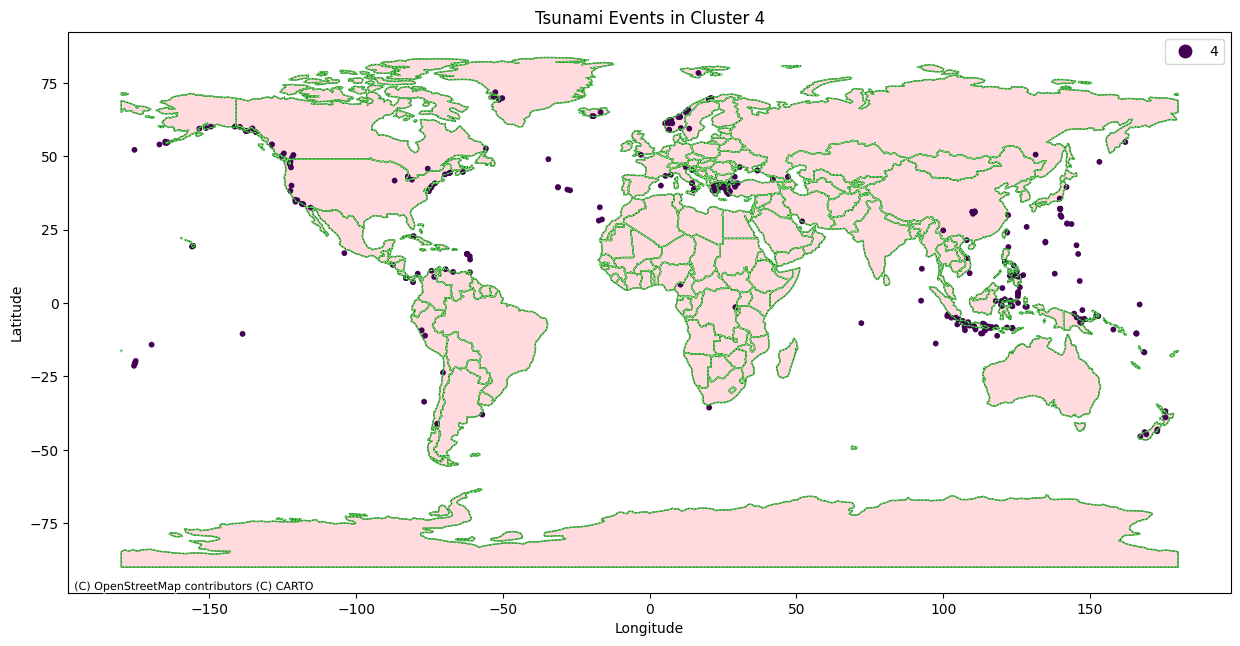

In [23]:
# Step 6: Analyzing a Specific Cluster
selected_cluster = 4  # Choose the cluster you want to analyze
cluster_data = tsunami_filtered[tsunami_filtered['Cluster'] == selected_cluster]
print(cluster_data.head())

gdf_cluster = gpd.GeoDataFrame(cluster_data, geometry=gpd.points_from_xy(cluster_data.Longitude, cluster_data.Latitude))
gdf_cluster.set_crs(epsg=4326, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot continents
world.boundary.plot(ax=ax, linewidth=1, color='green')
world.plot(ax=ax, color='lightpink', alpha=0.5)

# Plot oceans (simplified)
oceans.boundary.plot(ax=ax, linewidth=0.5, color='lightgreen', linestyle='dashed')

# Plot tsunami clusters
gdf_cluster.plot(column='Cluster', categorical=True, legend=True, markersize=10, cmap='viridis', ax=ax)

# Use EPSG:4326 CRS for the basemap and alternative tile provider
ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.CartoDB.Positron)

plt.title(f'Tsunami Events in Cluster {selected_cluster}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Cụm 4: rải rác ở các vùng khác nhau, bao gồm một số khu vực ven biển của Ấn Độ Dương và một vài điểm ở Đại Tây Dương. Đây có thể là những sự kiện sóng thần ít phổ biến hơn hoặc có nguyên nhân khác biệt so với các cụm khác.